In [1]:
import pacal as pc
from scipy.stats._distn_infrastructure import rv_continuous
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from aje.stats import genmaxima, gentruncated, pacal_to_scipy
from tqdm import tqdm

In [2]:
def von_mises_weibull_limit(pdf, cdf, upper_bound, r_eps=1e-3):
    w = upper_bound
    eps = r_eps * w
    x = (w-eps)
    return (w - x) * pdf(x) / (1-cdf(x))

In [3]:
x = np.linspace(0, 1, 100)
#Example, create a pacal distribution
X = pc.TrapezoidalDistr(0, 0.5, 0.5, 1)
Y = pc.BetaDistr(5,5)
Z = X+Y
Z = pacal_to_scipy(Z)

/home/default/miniforge3/envs/pymc/lib/python3.12/site-packages/pacal/standard_distr.py:422: RuntimeWarning: divide by zero encountered in log
  y = exp(self.lg_norm + log(x)*(self.alpha - 1) + log(1-x)*(self.beta - 1))


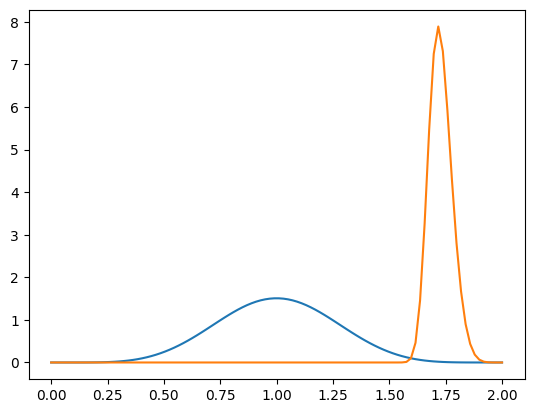

In [4]:
Z_max = genmaxima(Z, 1000)
x = np.linspace(Z_max.support()[1]*0.0, Z_max.support()[1], 100)
plt.plot(x, Z.pdf(x))
plt.plot(x, Z_max.pdf(x))

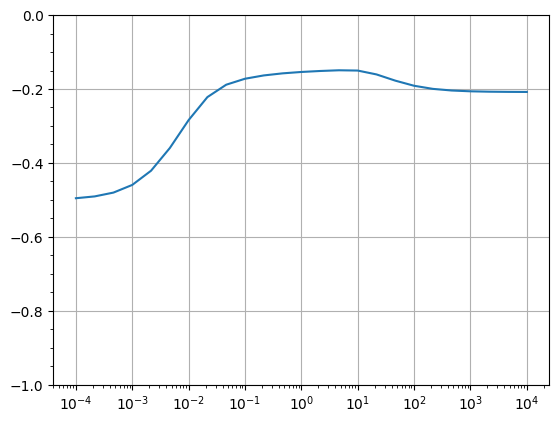

In [5]:
k_arr = np.logspace(-4, 4, 25, dtype=float)
xi_arr = np.zeros_like(k_arr)
xi_vm_arr = np.zeros_like(k_arr)
N = 10_000
for i, k in enumerate(k_arr):
    Z = X+k*Y
    Z = pacal_to_scipy(Z)
    Z_max = genmaxima(Z, N)
    xi_arr[i] = Z_max.get_genextreme_parameter()[-1]
    xi_vm_arr[i] = -1/von_mises_weibull_limit(Z_max.pdf, Z_max.cdf, Z_max.support()[1])

plt.plot(k_arr, xi_arr)
# plt.plot(k_arr, xi_vm_arr)
plt.xscale('log')
plt.ylim([-1.0, 0.0])
plt.grid()
plt.minorticks_on()

  0%|          | 0/25 [00:00<?, ?it/s]/home/default/miniforge3/envs/pymc/lib/python3.12/site-packages/pacal/standard_distr.py:426: RuntimeWarning: divide by zero encountered in log
  y[mask] = exp(self.lg_norm + log(x[mask])*(self.alpha - 1) + log(1-x[mask])*(self.beta - 1))
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in log
  return (-log(t))**5.0
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in log
  return 5.0*(-log(t))**5.0/(t*log(t))
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in divide
  return 5.0*(-log(t))**5.0/(t*log(t))
  4%|▍         | 1/25 [00:02<00:54,  2.28s/it]<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in log
  return (-log(t))**5.0
<lambdifygenerated-2>:2: RuntimeWarning: divide by zero encountered in log
  return 5.0*(-log(t))**5.0/(t*log(t))
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in multiply
  return 5.0*(-log(t))**5.0/(t*log(t))
 64%|██████▍   | 16/

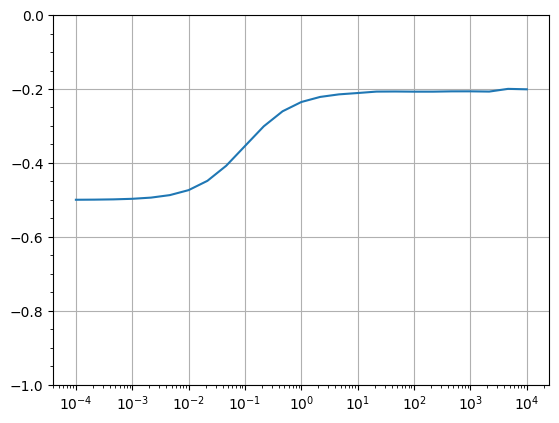

In [6]:
# With Gumbel copula
ci = pc.GumbelCopula(marginals=[X, Y], theta=5.0)

k_arr = np.logspace(-4, 4, 25, dtype=float)
xi_arr = np.zeros_like(k_arr)
xi_vm_arr = np.zeros_like(k_arr)
N = 10_000
for i, k in enumerate(tqdm(k_arr)):
    Mi = pc.TwoVarsModel(ci, X + k*Y)
    Z = Mi.eval()
    X_range = X.range()
    Y_range = Y.range()
    a = X_range[0] + k*Y_range[0]
    b = X_range[1] + k*Y_range[1]
    Z_scipy = pacal_to_scipy(Z, a=a, b=b)
    
    try:
        Z_max = genmaxima(Z_scipy, N)
        xi_arr[i] = Z_max.get_genextreme_parameter()[-1]
    except:
        xi_arr[i] = np.nan
        
    #xi_vm_arr[i] =-1/ von_mises_weibull_limit(Z_max.pdf, Z_max.cdf, Z_max.support()[1], r_eps=1e-4)

plt.plot(k_arr, xi_arr)
#plt.plot(k_arr, xi_vm_arr)
plt.xscale('log')
plt.ylim([-1.0, 0.0])
plt.grid()
plt.minorticks_on()